In [19]:
import pandas as pd
import numpy as np
import sys

sys.path.insert(0, '../visualize/')
sys.path.insert(0, '../models/')
sys.path.insert(0, '../features/')

from tcors_functions import *
from build_features import *
from counterprop import *
from linear_regression import *
from visualize import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score

random_state = 42

bin_step = 0.1

Prepare Data

In [20]:
build_features(step = bin_step)

In [21]:
df = load_features('model_features.pkl')
df.head()

,screen_id,week,project,site,dose,screen_sex,screen_age,carmine_nicotine,prp_change,prp_change_bin,prp_change_bin_label
37,J-A003,week12,project 1,uvm,15.8,Female,32,16.7,0.487500,"(0.4, 0.5]",4
50,J-A004,week12,project 1,uvm,0.4,Female,38,15.9,0.725225,"(0.7, 0.8]",7
76,J-A007,week12,project 1,uvm,15.8,Female,44,16.2,0.971223,"(0.9, 1.0]",9
89,J-A010,week12,project 1,uvm,15.8,Female,28,15.8,0.895522,"(0.8, 0.9]",8
117,J-A015,week12,project 1,uvm,15.8,Female,25,16.9,1.315152,"(1.3, 1.4]",13


In [22]:
df.dtypes

screen_id                 object
week                      object
project                   object
site                      object
dose                     float64
screen_sex                object
screen_age                 int64
carmine_nicotine         float64
prp_change               float64
prp_change_bin          category
prp_change_bin_label        int8
dtype: object

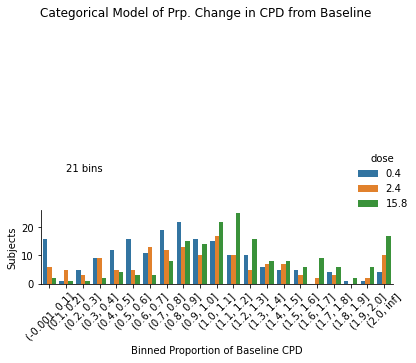

In [23]:
plot_bins(df)
plt.tight_layout()
plt.savefig("../../reports/figures/prp_change.png", dpi = 300)

In [24]:
cat_targets = ['prp_change_bin_label']
num_targets = ['prp_change']
# cat_predictors = ['project', 'site', 'dose', 'screen_sex']
num_predictors = ['screen_age', 'dose', 'project_num', 'sex_num', 'site_num', 'carmine_nicotine']
num_predictors_withoutnic = num_predictors[:]
num_predictors_withoutnic.remove('carmine_nicotine')

  # create numeric versions of categorical variables
df['project_num'] = df['project'].astype('category').cat.codes
df['site_num'] = df['site'].astype('category').cat.codes
df['sex_num'] = df['screen_sex'].astype('category').cat.codes

def preprocessing(df, num_predictors, random_state):
  
    X = df[num_predictors]
    y = df[cat_targets + num_targets]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    scaler = MinMaxScaler()
    scaler.fit(X_train[num_predictors])

    X_train[num_predictors] = scaler.transform(X_train[num_predictors])
    X_test[num_predictors] = scaler.transform(X_test[num_predictors])

    X_train_without_nic = X_train.copy()
    X_test_without_nic = X_test.copy()

    X_train_without_nic.drop(['carmine_nicotine'], axis=1, inplace=True)
    X_test_without_nic.drop(['carmine_nicotine'], axis=1, inplace=True)

    return X_train, X_test, X_train_without_nic, X_test_without_nic, y_train, y_test

X_train, X_test, X_train_without_nic, X_test_without_nic, y_train, y_test = preprocessing(
  df, num_predictors, random_state
  )

   

In [25]:
X_train_without_nic

,screen_age,dose,project_num,sex_num,site_num
6009,0.36,1.00000,1.0,0.0,1.0
6137,0.76,0.12987,1.0,1.0,0.0
3371,0.20,0.12987,0.5,0.0,1.0
5191,0.08,0.00000,1.0,1.0,1.0
8731,0.68,0.12987,0.5,1.0,0.5
...,...,...,...,...,...
2200,0.24,0.12987,0.5,1.0,1.0
5165,0.58,0.12987,1.0,0.0,1.0
6455,0.74,0.00000,1.0,1.0,0.0
7883,0.40,1.00000,0.0,0.0,0.5


In [26]:
y_train['prp_change']

6009    1.791045
6137    0.623762
3371    0.913043
5191    0.367213
8731    2.920000
          ...   
2200    0.586207
5165    0.652273
6455    1.065217
7883    0.436137
2146    0.828571
Name: prp_change, Length: 410, dtype: float64

## Linear Regression

In [27]:
without_nic = fit_linear(
    X_train_without_nic,
    X_test_without_nic,
    y_train[['prp_change']],
    y_test[['prp_change']],
    bin_step = bin_step,
    random_state=random_state
)

with_nic = fit_linear(
    X_train,
    X_test,
    y_train[['prp_change']],
    y_test[['prp_change']],
    bin_step = bin_step,
    random_state=random_state
)

Performance when treated as a regression

In [28]:
wo_nic_avg = without_nic.avg_scores
wo_nic_avg['label'] = 'without_nic'

w_nic_avg = with_nic.avg_scores
w_nic_avg['label'] = 'with_nic'

lm_r2 = pd.concat([wo_nic_avg, w_nic_avg])
lm_r2['model'] = 'linear_model'

lm_r2

,mean_cv_r2,sd_cv_r2,test_r2,label,model
1,0.083358,0.075021,0.139511,without_nic,linear_model
1,0.074846,0.075885,0.092326,with_nic,linear_model


Performance when treated as a classifier

In [29]:
lm_f1 = pd.DataFrame(
    {
        "f1" : [without_nic.clf_mets, with_nic.clf_mets],
        "label" : ["without_nic", "with_nic"],
        "model" : ['linear_model*', 'linear_model*']
    }
)
lm_f1


,f1,label,model
0,0.106796,without_nic,linear_model*
1,0.116505,with_nic,linear_model*


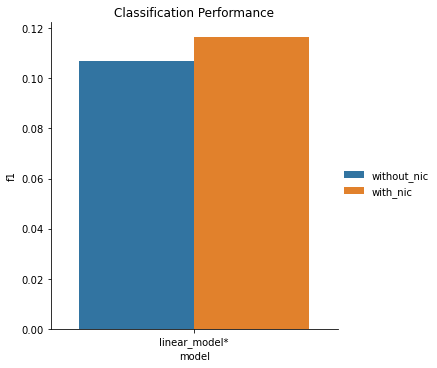

In [30]:
clf_plt(lm_f1)

## Counter-Propagation  

In [31]:
# np.save(file = "../../data/processed/X_train.npy", arr= X_train_without_nic)
# np.save(file = "../../data/processed/y_train.npy", arr = y_train['prp_change_bin_label'])


y_train_onehot = onehot_output(y_train['prp_change_bin_label'])
X_train_array = np.array(X_train_without_nic)

y_train_labels = np.array(y_train['prp_change_bin_label'].reset_index())[:, 1]


In [32]:
y_train_labels.shape

(410,)

Cross Validation    

In [33]:
def counterprp_fit_predict(
        X_train: np.array, X_test: np.array, 
        y_train_onehot: np.array, y_test_onehot: np.array, 
        y_test_labels: pd.Series, random_init=False,
        epochs=25):

    mod = train_model(
        X_train, 
        y_train_onehot,
        random_init=random_init, 
        n_hidden = len(X_train), 
        epochs=25
        )
    pred1 = predict_model(np.array(X_test), y_test_onehot, mod.pass1_weights)
    pred2 = predict_model(np.array(X_test), y_test_onehot, mod.pass2_weights)   

    f1_pred1 = f1_score(y_test_labels, pred1.predict_cat, average = 'micro')
    f1_pred2 = f1_score(y_test_labels, pred2.predict_cat, average = 'micro')

    result = namedtuple("result", ["pred1", "pred2", "f1_pred1", "f1_pred2", "rmse"])

    return result(pred1, pred2, f1_pred1, f1_pred2, mod.rmse_values)

def cv_counterprop(X_train_array, y_train_onehot, y_labels, random_init=False, cv=5):
    kf = KFold(n_splits=cv)

    pred1 = []
    pred2 = []
    f1_pred1 = []
    f1_pred2 = []
    rmse_vals = {}

    s = 1
    for train_index, test_index in kf.split(X_train_array):
        X_train = X_train_array[train_index]
        X_test = X_train_array[test_index]

        y_train = y_train_onehot[train_index]
        y_test = y_train_onehot[test_index]

        y_labs = y_labels[test_index]

        fit = counterprp_fit_predict(X_train, X_test, y_train, y_test, y_labs, random_init=random_init)
        pred1.append(fit.pred1)
        pred2.append(fit.pred2)
        f1_pred1.append(fit.f1_pred1)
        f1_pred2.append(fit.f1_pred2)

        rmse_vals[s] = fit.rmse
        s += 1


    return pred1, pred2, f1_pred1, f1_pred2, rmse_vals

pred1, pred2, f1_pred1, f1_pred2, rmse = cv_counterprop(X_train_array, y_train_onehot, y_train_labels, random_init=False)



KeyboardInterrupt: 

In [ ]:
p1 = {
    "mean_cv_f1" : np.mean(f1_pred1), 
    "mean_cv_std" : np.std(f1_pred1),
    "model" : "fixed_w1"
    }

p2 = {
    "mean_cv_f1" : np.mean(f1_pred2), 
    "mean_cv_std" : np.std(f1_pred2),
    "model" : "free_w1"
    }

pd.concat([pd.DataFrame(p1, index = [1]), pd.DataFrame(p2, index = [1])])

,mean_cv_f1,mean_cv_std,model
1,0.075610,0.031235,fixed_w1
1,0.068293,0.009756,free_w1


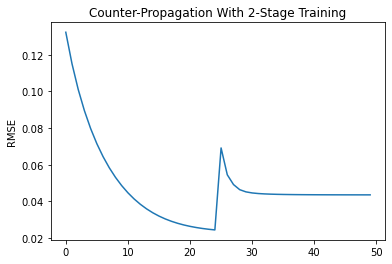

In [ ]:
mod = train_model(
        X_train_array, 
        y_train_onehot, 
        n_hidden = len(X_train_array), 
        epochs=25
        )
plt.plot(mod.rmse_values)
plt.ylabel("RMSE")
plt.title("Counter-Propagation With 2-Stage Training")
plt.savefig("../../reports/figures/counterprop_train.png", dpi = 300)
plt.show()


In [ ]:
rmse_df = pd.DataFrame(rmse)
rmse_df = pd.melt(rmse_df, var_name = "fold", value_name = "rmse")
rmse_df['epoch'] = rmse_df.groupby('fold').cumcount()
# rmse_df['avg_rmse'] = rmse_df.groupby(['epoch']).mean()
rmse_df


,fold,rmse,epoch
0,1,0.146759,0
1,1,0.128717,1
2,1,0.113748,2
3,1,0.101121,3
4,1,0.090339,4
...,...,...,...
245,5,0.048305,45
246,5,0.048302,46
247,5,0.048299,47
248,5,0.048297,48


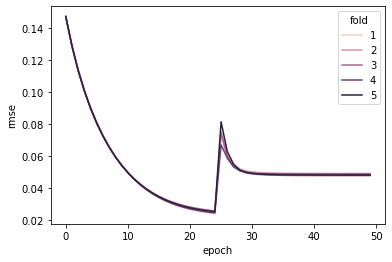

In [ ]:
rmse_cv(rmse, title="Cross-Validated Training: Fixed Initialization")
plt.savefig("../../reports/figures/counterprop_cv_fixed.png", dpi = 300)

Repeat the same with random initialization

In [ ]:
pred1, pred2, f1_pred1, f1_pred2, rmse = cv_counterprop(X_train_array, y_train_onehot, y_train_labels, random_init=True)

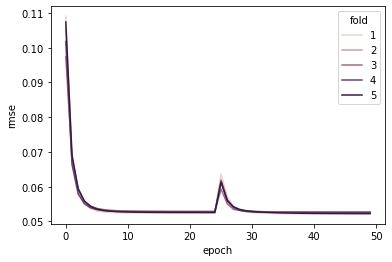

In [ ]:
rmse_cv(rmse, title="Cross-Validated Training: Random Initialization")
plt.savefig("../../reports/figures/counterprop_cv_random.png", dpi = 300)

In [ ]:
p1 = {
    "mean_cv_f1" : np.mean(f1_pred1), 
    "mean_cv_std" : np.std(f1_pred1),
    "model" : "fixed_w1"
    }

p2 = {
    "mean_cv_f1" : np.mean(f1_pred2), 
    "mean_cv_std" : np.std(f1_pred2),
    "model" : "free_w1"
    }

pd.concat([pd.DataFrame(p1, index = [1]), pd.DataFrame(p2, index = [1])])

## Backpropagation